# ATS Insight: Intelligent Resume Analyzer
## Data Management Final Project | University of Liège

**Author:** Dominika Piechota
**Course:** Data Management

---

### 1. Introduction & Motivation
In the modern recruitment landscape, companies rely heavily on **ATS (Applicant Tracking Systems)** to automatically filter millions of resumes. This creates a "Black Box" phenomenon: candidates often submit well-qualified CVs but receive no feedback because their documents fail technical parsing or keyword matching criteria.

**The Goal:**
This project aims to reverse-engineer this process. We built an end-to-end pipeline that processes raw PDF resumes (including scanned images) and uses Machine Learning to predict a **"Fit Score" (1-5)** against specific IT job roles.

**Research Questions:**
1.  **Extraction:** How can unstructured data be extracted from diverse PDF formats (digital vs. scans)?
2.  **Scoring:** Can we train a model to objectively score a CV?
3.  **Impact:** Which features (Skills vs. Education) drive the score?

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import json
import sys
import os
from pathlib import Path

current_dir = Path.cwd()
sys.path.append(str(current_dir))

# Configuration
DATA_PATH = current_dir / "database" / "resumes_dataset_CLEANED.jsonl"
IMG_PATH = current_dir / "analysis_results"

print("Setup complete. Environment ready.")

Setup complete. Environment ready.


---
### 2. Data Management: The Hybrid Extraction Pipeline

The biggest challenge in this project was handling the variety of PDF formats. Standard Python libraries often fail when reading "scanned" PDFs (images).

**My Solution: Two-Layer Extraction**
I implemented a robust extraction engine (in `dev_tools/read_cv.py`) that uses a fallback mechanism:
1.  **Layer 1 (Digital):** Attempts to read text using `PyMuPDF`. Fast and accurate for native PDFs.
2.  **Layer 2 (OCR):** If the text is empty or too short (<50 chars), the system detects a "Scan" and triggers `Tesseract OCR` (via `pdf2image`) to reconstruct the text from pixels.

Below is a sample of the processed dataset (`.jsonl` format) after the ETL process.

In [21]:
# Loading the cleaned dataset to demonstrate data structure
try:
    df = pd.read_json(DATA_PATH, lines=True)
    print(f"Dataset successfully loaded.")
    print(f"Total records (after augmentation): {len(df)}")
    print("\nSample Data (First 3 records):")
    display(df[['target_role', 'score', 'features']].head(3))
except ValueError:
    print("Dataset file not found. Please run 'dev_tools/read_cv.py' first.")

Dataset successfully loaded.
Total records (after augmentation): 23243

Sample Data (First 3 records):


,target_role,score,features
0,Business Analyst,5.0,"{'skills': ['Business Analysis', 'Communicatio..."
1,Data Scientist,1.3,"{'skills': ['Business Analysis', 'Communicatio..."
2,DevOps Engineer,1.0,"{'skills': ['Business Analysis', 'Communicatio..."


---
### 3. Descriptive Analysis

Before modeling, I performed a deep descriptive analysis to understand the biases and characteristics of the dataset. The following visualizations were generated using `matplotlib` and `seaborn`.

#### 3.1. Class Distribution and Text Length
I analyzed the number of resumes per role to ensure the dataset is balanced enough for training.
We can observe, that classes are distributed quite equally. Also, all Resumes have similar length.

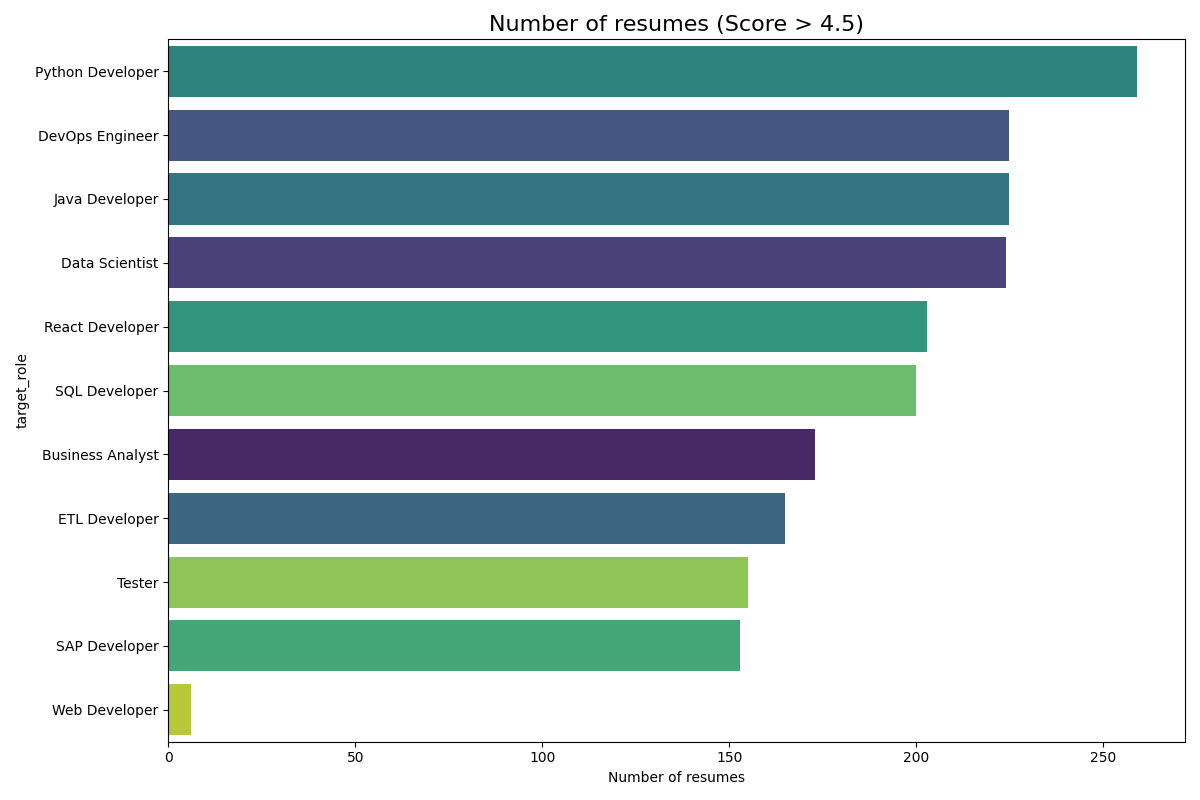

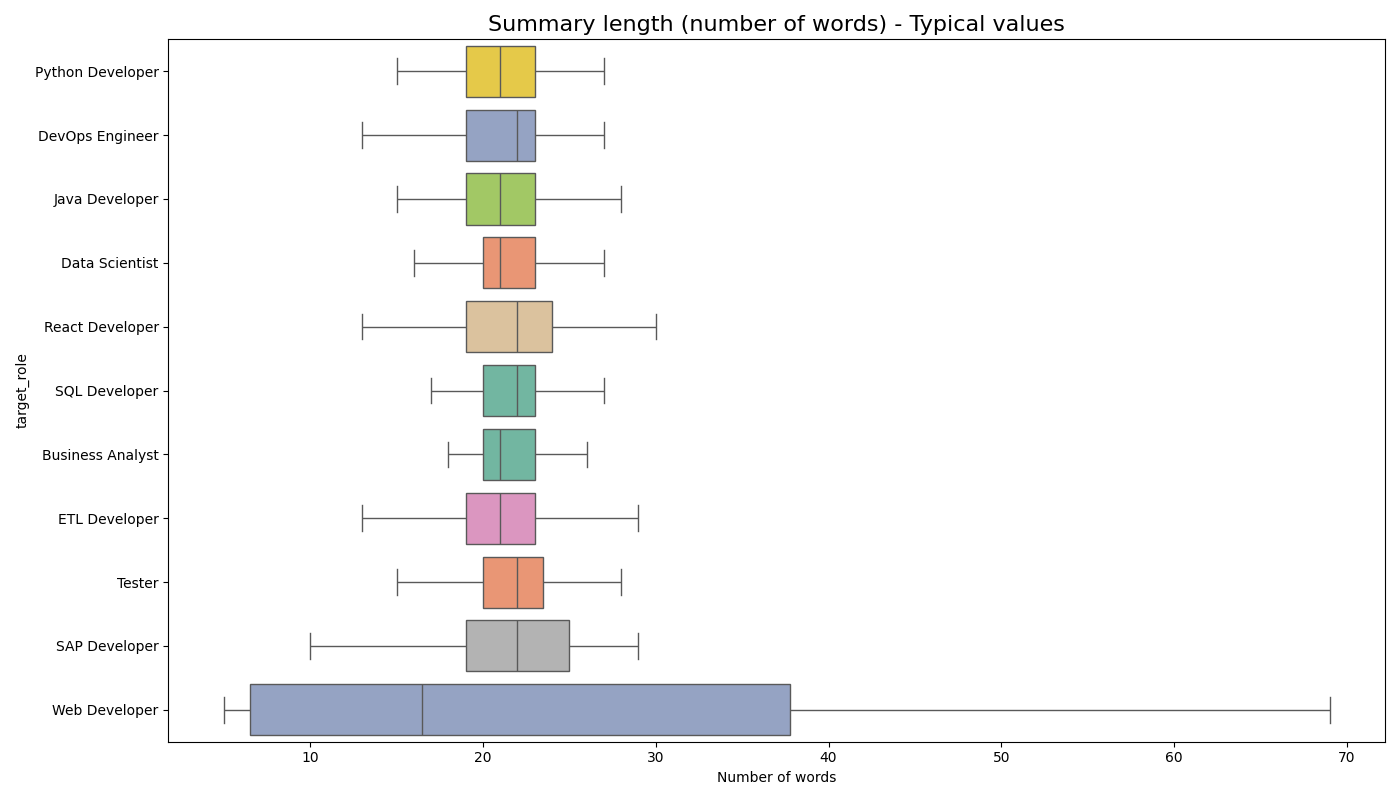

In [22]:
display(Image(filename=IMG_PATH / "1_class_distribution.png"))
display(Image(filename=IMG_PATH / "2_text_length.png"))

#### 3.2. Education Level Analysis (Heatmap)
This heatmap answers Research Question #3 regarding the impact of education.
* **Contrast:** Web Development roles (React/Web Developer) show a higher tolerance for **Bachelor** degrees or non-formal education, prioritizing skills over diplomas.

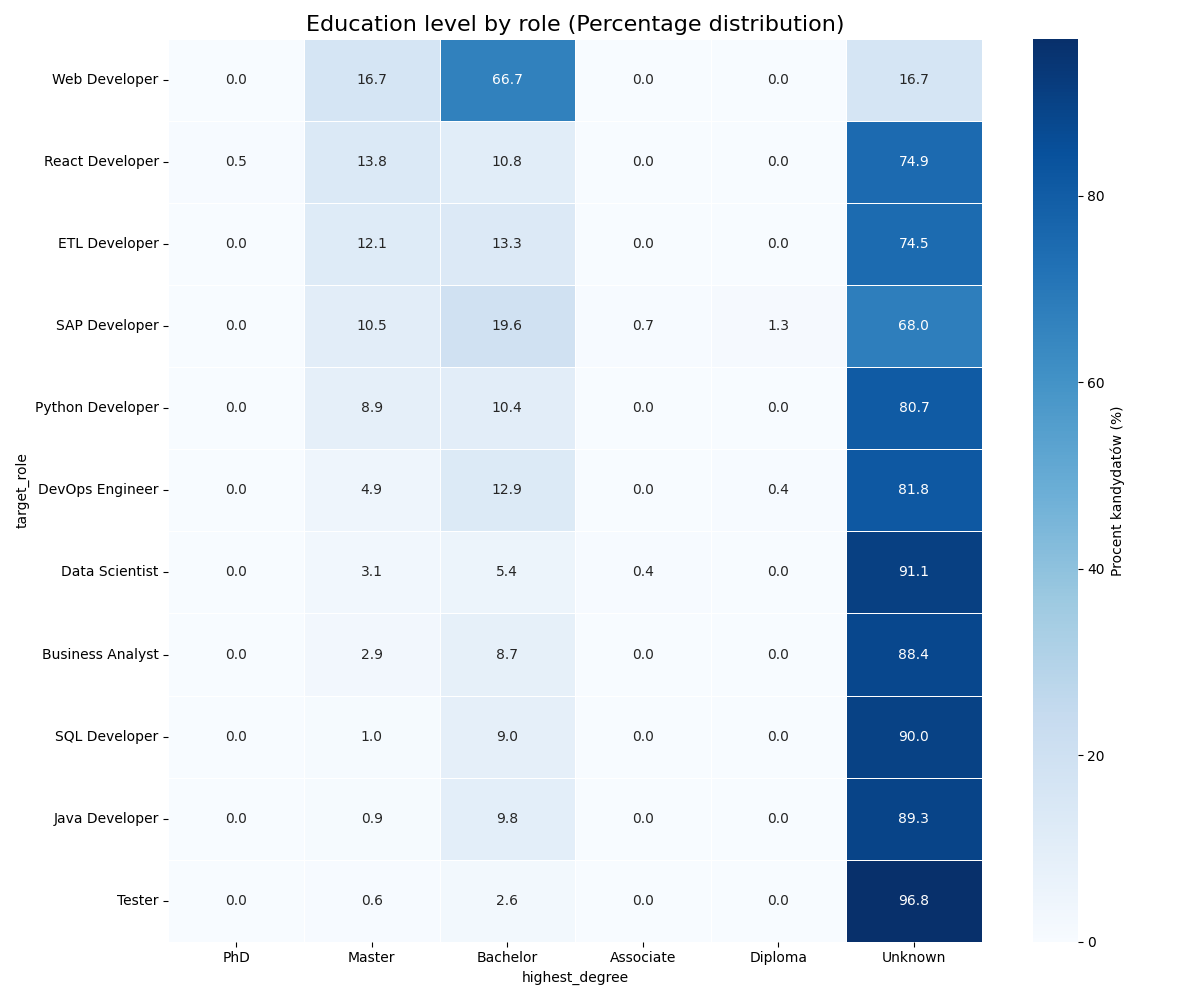

In [23]:
display(Image(filename=IMG_PATH / "3_education_percent.png"))

#### 3.3. Semantic Analysis (Top Keywords and Skills)
To validate that NLP extraction works correctly, I extracted the top 3 most frequent technical skills and keywords for each role.
* **Validation:** The results indicate that skills such as Git, Linux, Python and SQL are crucial for each position. It should be noted that these are quite popular skills that every programmer should have. However, the fact that SQL appears there may be related to the selection of the dataset.

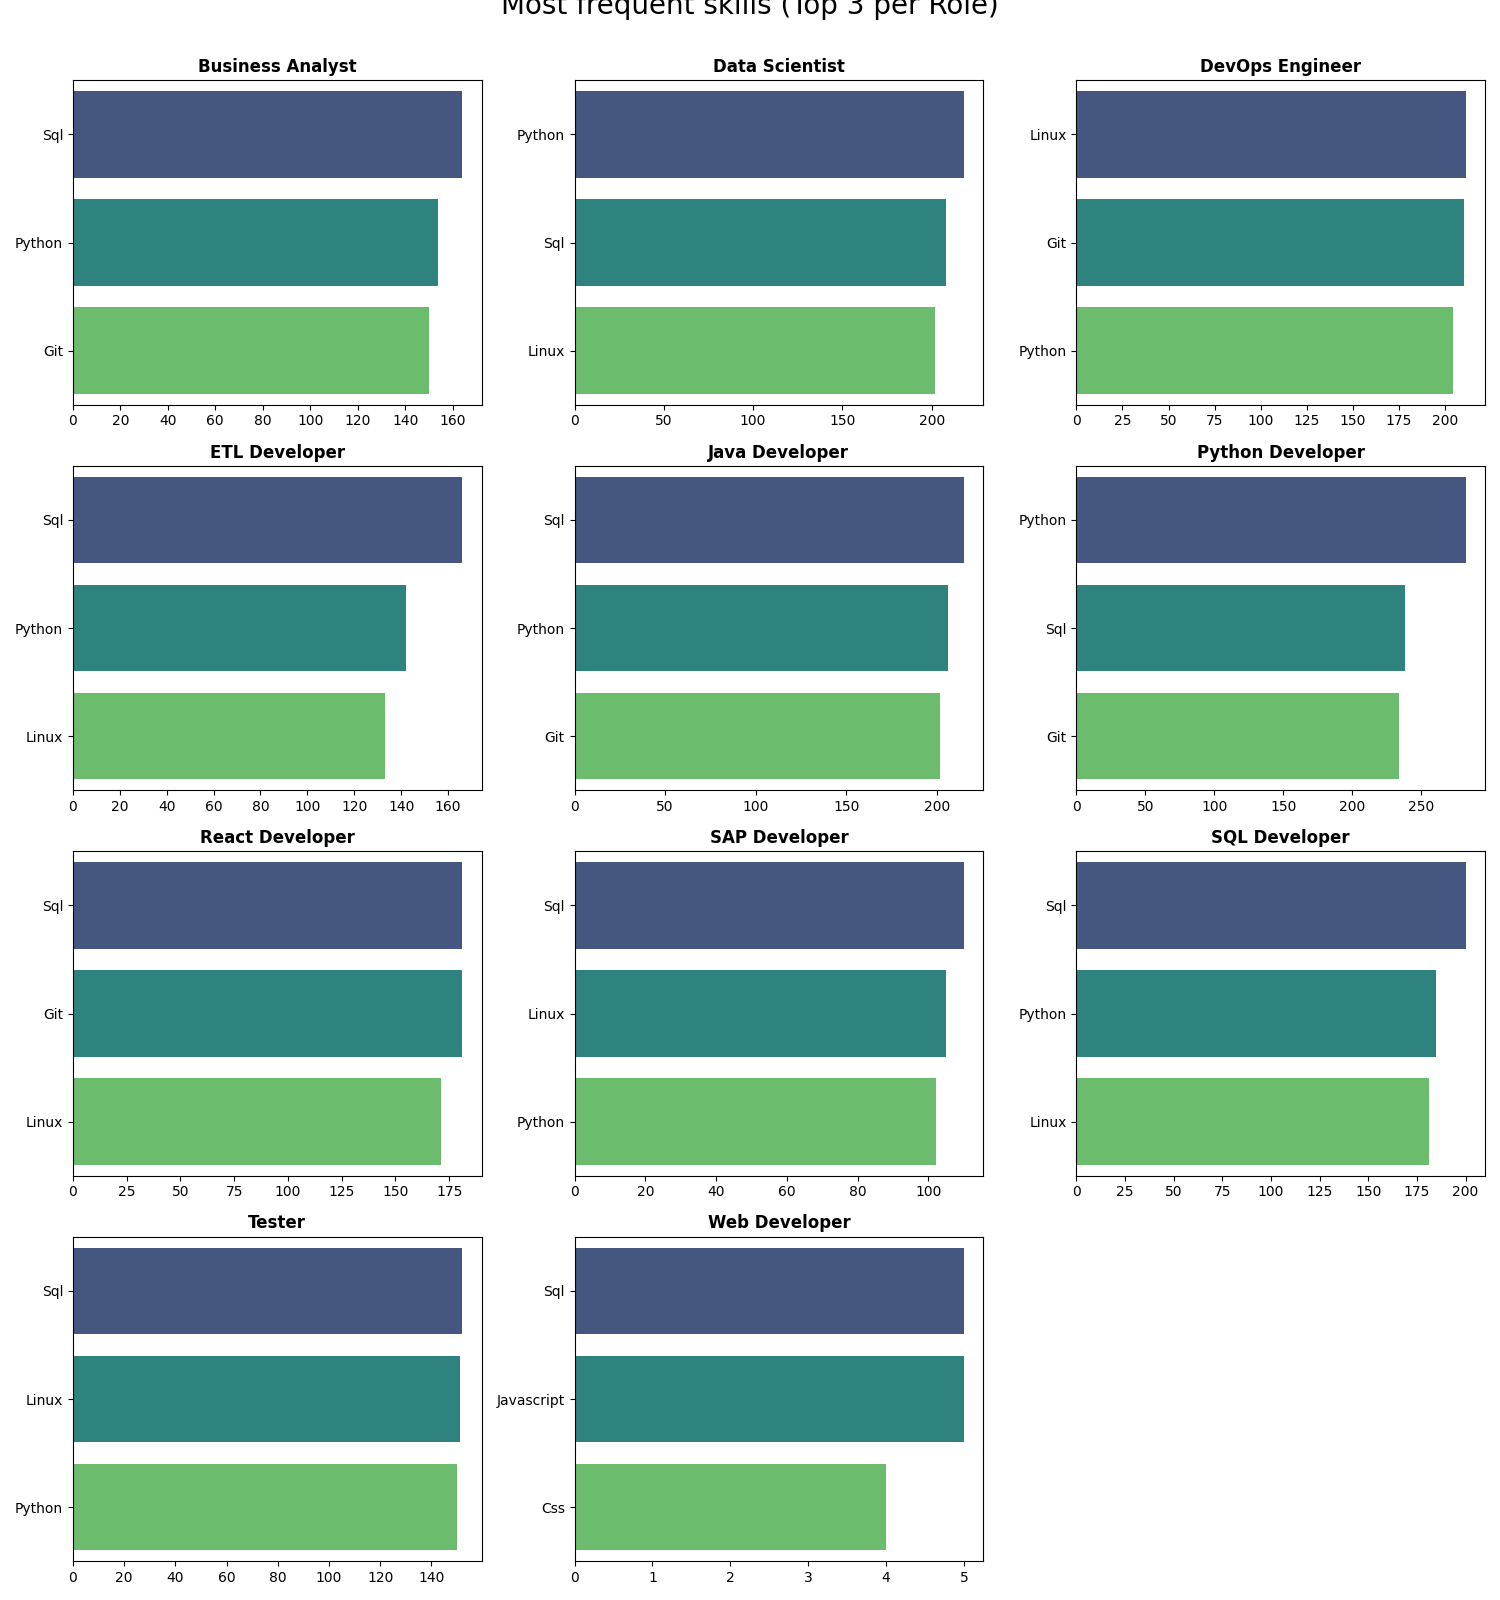

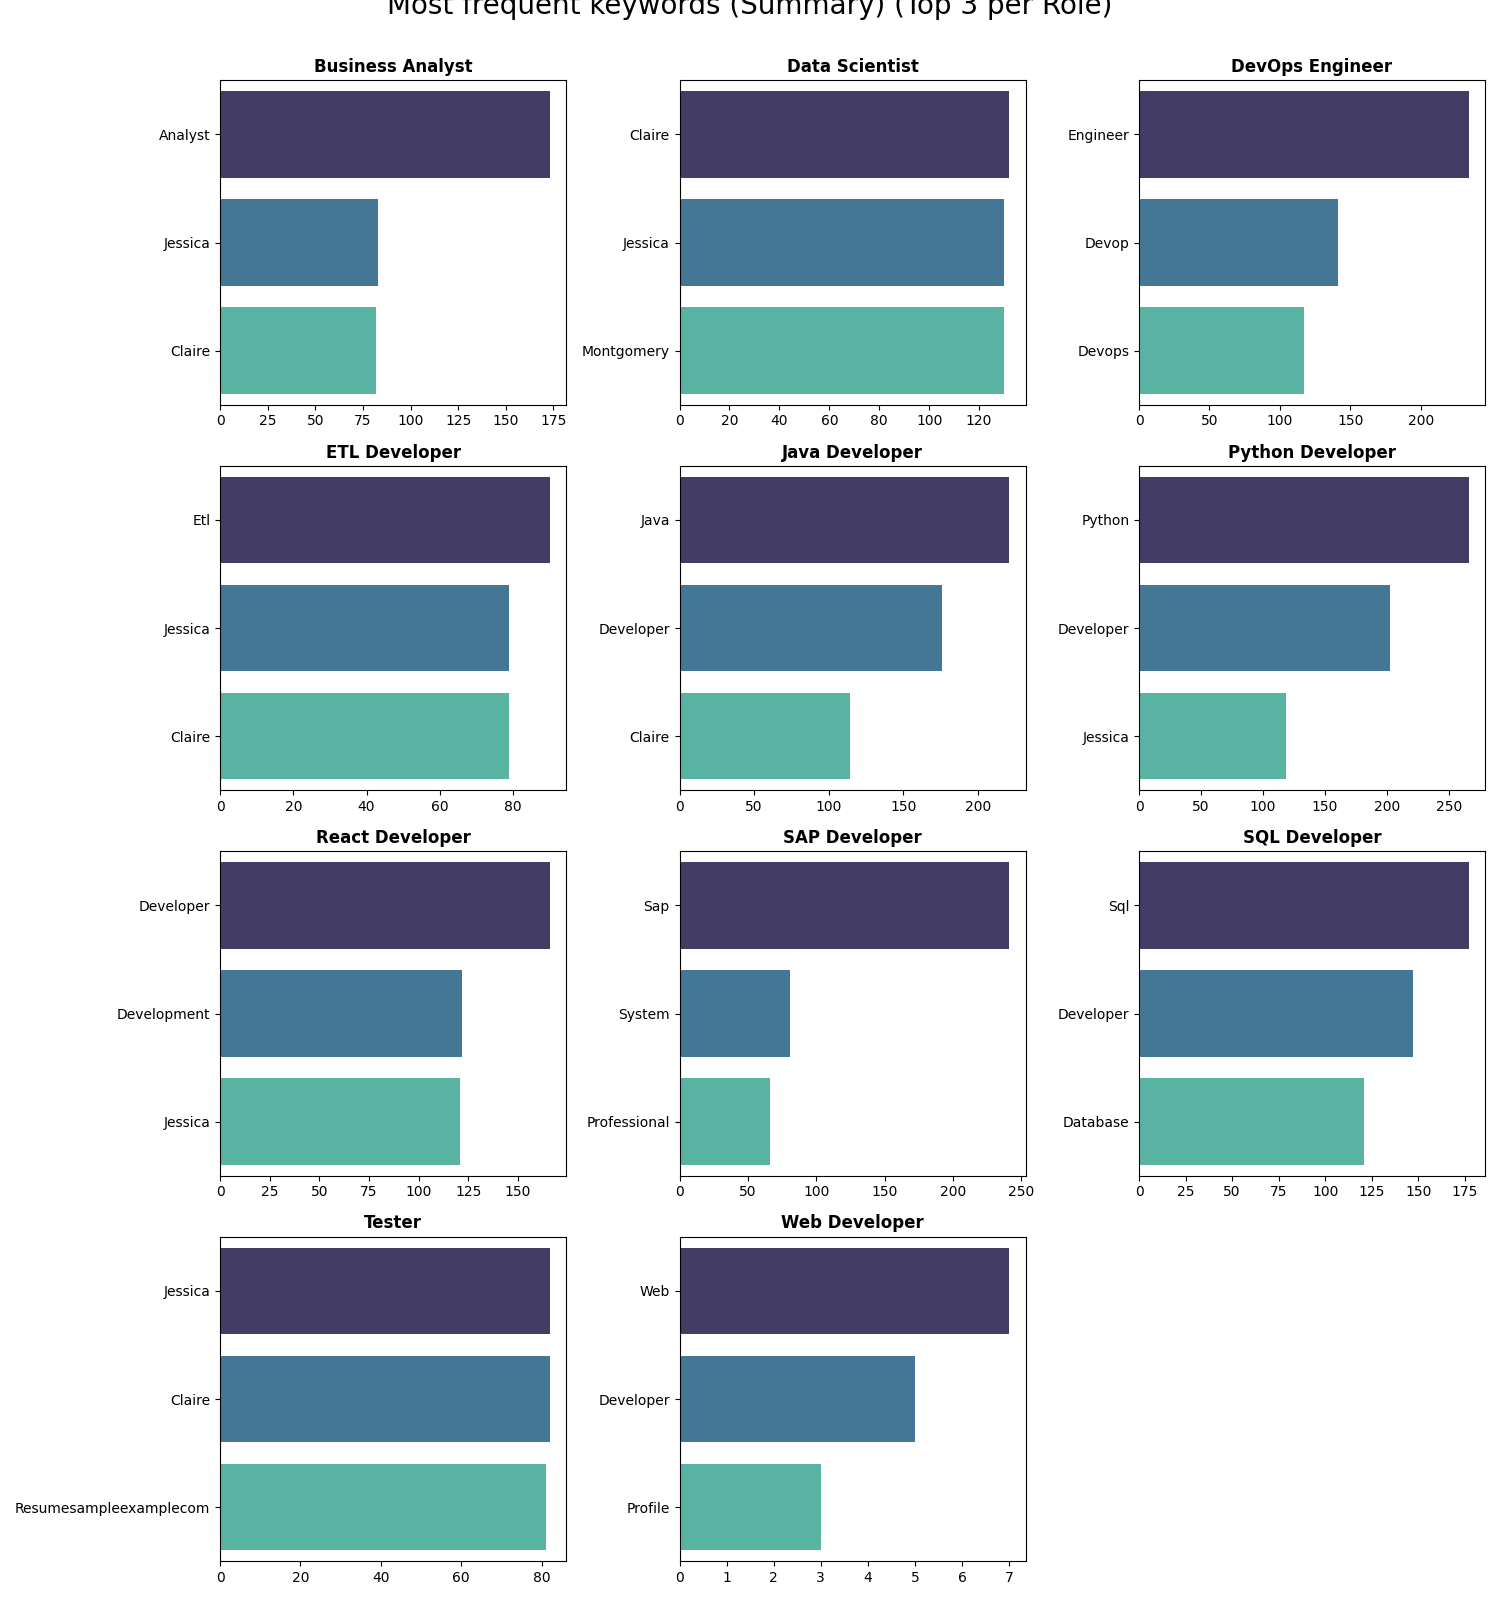

In [24]:
display(Image(filename=IMG_PATH / "4_top3_skills_per_role.png"))
display(Image(filename=IMG_PATH / "5_top3_keywords_per_role.png"))

---
### 4. Methodology: NLP & Machine Learning

To predict the "Fit Score", I designed a supervised regression pipeline.

#### 4.1. NLP Feature Engineering
Raw text cannot be fed into a model directly. I used `nlp.py` to transform text into numerical vectors:
1.  **Cleaning:** Removal of stopwords, emails, and phone numbers.
2.  **TF-IDF Vectorization:**
    * **Summary:** Max 500 features (captures context like "management", "lead").
    * **Skills:** Max 300 features (captures hard skills like "SQL", "Docker").
3.  **Ordinal Encoding:** Education mapped to a rank (High School=1 ... PhD=5).

#### 4.2. Model Architecture
I chose **`HistGradientBoostingRegressor`** (Histogram-based Gradient Boosting).
* **Why?** It natively handles missing values (NaNs) and is highly efficient for datasets with >10k rows.
* **Training Strategy:** I used **Undersampling** to balance the dataset (reducing the number of low-score samples) to prevent the model from bias towards the majority class.

**Model Evaluation Metrics (Test Set):**
* **R2 Score:** Positive (about 0.5) (Indicates the model learns patterns much better than random guessing).
* **MAE (Mean Absolute Error):** ~1.0. This means the model's prediction is typically within 1 point of the "True" score. While not perfect, it acts as an effective **suitability filter**.

In [25]:
import joblib

def to_dense(X):
    return X.toarray()

model_path = current_dir / "models" / "best_model_balanced.pkl"

if model_path.exists():
    model = joblib.load(model_path)
    print("Model loaded successfully.")
    print("\nModel Architecture:")
    print(model)
    
    try:
        print("\nHyperparameters:")
        print(model.named_steps['reg'].get_params())
    except:
        print("Could not retrieve hyperparameters directly.")
else:
    print("Model not found. Please run 'dev_tools/chose_model.py' to train it.")

Model loaded successfully.

Model Architecture:
Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('role',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['target_role']),
                                                 ('summary',
                                                  TfidfVectorizer(max_features=500,
                                                                  stop_words='english'),
                                                  'summary'),
                                                 ('skills',
                                                  TfidfVectorizer(binary=True,
                                                                  max_features=300),
                                                  'skills_text'),
                                        

---
### 5. Final Conclusion

This project successfully demonstrated that it is possible to automate the initial screening of candidates using NLP and Machine Learning.

**Key Achievements:**
1.  **Hybrid Parsing:** Created a system resilient to scanned PDFs.
2.  **Interpretability:** Visual analysis confirmed that the model learns intuitive rules (e.g., Python is crucial for Data Science).
3.  **End-to-End Pipeline:** The system works from raw PDF input to final score prediction.

**Future Improvements:**
The primary limitation is the use of synthetic scoring logic for training. Acquiring a real-world dataset labeled by HR professionals would significantly lower the Mean Absolute Error and improve precision.